# LAB | Hyperparameter Tuning

**Load the data**

Finally step in order to maximize the performance on your Spaceship Titanic model.

The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

So far we've been training and evaluating models with default values for hyperparameters.

Today we will perform the same feature engineering as before, and then compare the best working models you got so far, but now fine tuning it's hyperparameters.

In [21]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [3]:
# Split Cabin into Deck, CabinNumber, and Side
spaceship[['Deck', 'CabinNumber', 'Side']] = spaceship['Cabin'].str.split('/', expand=True)

# Convert CabinNumber to numeric
spaceship['CabinNumber'] = pd.to_numeric(spaceship['CabinNumber'], errors='coerce')

# Drop the columns that we don't need
spaceship.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)

# Classify the non-numeric columns
non_numeric_cols = spaceship[['HomePlanet', 'Destination', 'Deck', 'Side']]

# Do dummy encoding on the non-numeric columns
spaceship = pd.get_dummies(spaceship, columns=non_numeric_cols.columns, drop_first=True)

In [4]:
spaceship.corrwith(spaceship['Transported']).sort_values(ascending=False)

Transported                  1.000000
CryoSleep                    0.468645
HomePlanet_Europa            0.176916
Deck_B                       0.144733
Deck_C                       0.108193
Side_S                       0.101455
FoodCourt                    0.046566
HomePlanet_Mars              0.019544
Deck_G                       0.016269
ShoppingMall                 0.010141
Destination_PSO J318.5-22    0.000092
Deck_T                      -0.014568
Deck_D                      -0.034046
VIP                         -0.037650
CabinNumber                 -0.045097
Age                         -0.075026
Deck_F                      -0.087753
Destination_TRAPPIST-1e     -0.094700
Deck_E                      -0.097965
VRDeck                      -0.207075
Spa                         -0.221131
RoomService                 -0.244611
dtype: float64

In [5]:
spaceship.dropna(inplace=True)

**Perform Train Test Split**

In [6]:
#Select the columns you want to use for your model
X = spaceship[['CryoSleep', 'HomePlanet_Europa', 'RoomService', 'Side_S', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck_B', 'Destination_TRAPPIST-1e', 'Age']]
y = spaceship['Transported'] 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Normalize data**

In [7]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

normalizer = MinMaxScaler()

normalizer.fit(X_train)

MinMaxScaler()

In [8]:
X_train_norm = normalizer.fit_transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [9]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,CryoSleep,HomePlanet_Europa,RoomService,Side_S,FoodCourt,ShoppingMall,Spa,VRDeck,Deck_B,Destination_TRAPPIST-1e,Age
0,0.0,0.0,0.10504,1.0,0.000000,0.001532,0.000000,0.000000,0.0,1.0,0.189873
1,0.0,0.0,0.00000,0.0,0.103311,0.000298,0.000000,0.003295,0.0,0.0,0.253165
2,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.024902,0.000049,0.0,1.0,0.291139
3,0.0,1.0,0.00000,0.0,0.026599,0.000000,0.003883,0.077055,0.0,1.0,0.683544
4,1.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.088608


**Standarize data**

In [10]:
# Standardize data
standardizer = StandardScaler()

standardizer.fit(X_train)

StandardScaler()

In [11]:
X_train_std = standardizer.fit_transform(X_train)

X_test_std = standardizer.transform(X_test)

In [12]:
X_test_std = pd.DataFrame(X_test_std, columns = X_test.columns)
X_test_std.head()

,CryoSleep,HomePlanet_Europa,RoomService,Side_S,FoodCourt,ShoppingMall,Spa,VRDeck,Deck_B,Destination_TRAPPIST-1e,Age
0,-0.728272,-0.570626,-0.348335,-1.006550,-0.288483,0.203240,-0.273823,0.102883,-0.32487,-1.459181,0.764297
1,1.373112,-0.570626,-0.348335,0.993492,-0.288483,-0.277229,-0.274702,-0.267862,-0.32487,0.685316,0.833307
2,-0.728272,-0.570626,-0.235114,-1.006550,-0.285387,-0.277229,0.025806,-0.102304,-0.32487,0.685316,-0.684912
3,1.373112,-0.570626,-0.348335,-1.006550,-0.288483,-0.277229,-0.274702,-0.267862,-0.32487,0.685316,-0.270852
4,-0.728272,-0.570626,-0.321602,-1.006550,-0.081715,0.820102,-0.259765,0.054448,-0.32487,0.685316,0.695287


- Now let's use the best model we got so far in order to see how it can improve when we fine tune it's hyperparameters.

In [19]:
models = {'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)}

datasets = {'Raw': (X_train, X_test),
    'Standardized': (X_train_std, X_test_std),
    'Normalized': (X_train_norm, X_test_norm)}

results = []

for dataset_name, (X_train_set, X_test_set) in datasets.items():
    for model_name, model in models.items():
        print(f'Training {model_name} with {dataset_name} data...')
        
        model.fit(X_train_set, y_train)
        
        y_pred = model.predict(X_test_set)
        
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({'Model': model_name,
            'Dataset': dataset_name,
            'Accuracy': accuracy})

        print(f'{model_name} Accuracy with {dataset_name} data: {accuracy:.4f}')

results_df = pd.DataFrame(results)
results_df.sort_values('Accuracy', ascending=False).head(20)

Training Logistic Regression with Raw data...
Logistic Regression Accuracy with Raw data: 0.7975
Training K-Nearest Neighbors with Raw data...
K-Nearest Neighbors Accuracy with Raw data: 0.7763
Training Decision Tree with Raw data...
Decision Tree Accuracy with Raw data: 0.7466
Training Random Forest with Raw data...
Random Forest Accuracy with Raw data: 0.8017
Training Bagging with Raw data...
Bagging Accuracy with Raw data: 0.7876
Training Gradient Boosting with Raw data...
Gradient Boosting Accuracy with Raw data: 0.8045
Training AdaBoost with Raw data...
AdaBoost Accuracy with Raw data: 0.8024
Training Logistic Regression with Standardized data...
Logistic Regression Accuracy with Standardized data: 0.7996
Training K-Nearest Neighbors with Standardized data...
K-Nearest Neighbors Accuracy with Standardized data: 0.7622
Training Decision Tree with Standardized data...
Decision Tree Accuracy with Standardized data: 0.7466
Training Random Forest with Standardized data...
Random Forest

,Model,Dataset,Accuracy
12,Gradient Boosting,Standardized,0.804517
19,Gradient Boosting,Normalized,0.804517
5,Gradient Boosting,Raw,0.804517
17,Random Forest,Normalized,0.803105
20,AdaBoost,Normalized,0.802399
6,AdaBoost,Raw,0.802399
13,AdaBoost,Standardized,0.802399
3,Random Forest,Raw,0.801694
10,Random Forest,Standardized,0.800988
7,Logistic Regression,Standardized,0.799577


- Evaluate your model

              precision    recall  f1-score   support

       False       0.82      0.77      0.79       688
        True       0.79      0.84      0.82       729

    accuracy                           0.80      1417
   macro avg       0.81      0.80      0.80      1417
weighted avg       0.81      0.80      0.80      1417



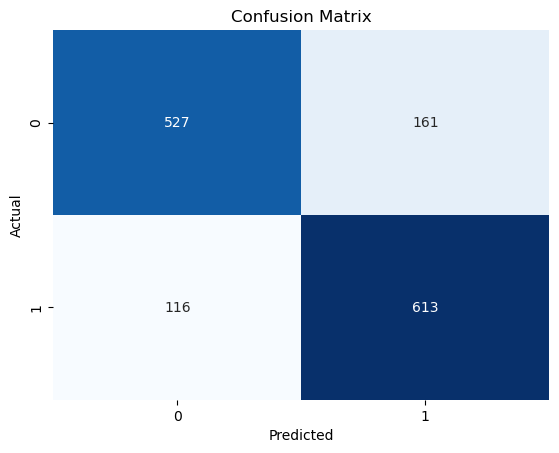

In [23]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)
y_pred_prob = gb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Grid/Random Search**

For this lab we will use Grid Search.

- Define hyperparameters to fine tune.

In [24]:
param_grid = {'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]}

- Run Grid Search

In [25]:
gb_model = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train_std, y_train)

print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}


- Evaluate your model

In [26]:
best_gb_model = grid_search.best_estimator_
y_pred = best_gb_model.predict(X_test_std)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Gradient Boosting accuracy after tuning: {accuracy:.4f}')

Best Gradient Boosting accuracy after tuning: 0.8059


              precision    recall  f1-score   support

       False       0.81      0.78      0.80       688
        True       0.80      0.83      0.81       729

    accuracy                           0.81      1417
   macro avg       0.81      0.81      0.81      1417
weighted avg       0.81      0.81      0.81      1417



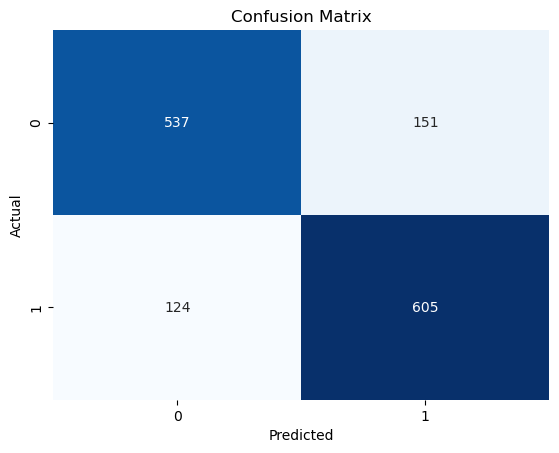

In [27]:
best_gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=200, subsample=0.8, random_state=42)
best_gb_model.fit(X_train, y_train)

y_pred = best_gb_model.predict(X_test)
y_pred_prob = best_gb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()